#### [ 뉴스 토픽 분류 AI ]
- 다중 분류 모델
- 한국어 뉴스 헤드라인을 이용하여, 뉴스의 주제를 분류하는 알고리즘 개발

In [1]:
# ------ LIBRARY -------#
import numpy as np
import os
import pickle
import sys
import pandas as pd
import re
import seaborn as sns

# torch
import torch
import torch.cuda.amp as amp
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *

import torch.nn as nn
import torch.nn.functional as F

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, MultiStepLR, OneCycleLR

#

import math
import torch
from torch.optim.optimizer import Optimizer, required
import torch_optimizer as optim
from collections import defaultdict
import itertools as it

import tqdm
import random

#import time
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import transformers

# transformer
from transformers import XLMPreTrainedModel, XLMRobertaModel, XLMRobertaConfig, XLMRobertaTokenizer
from transformers import XLMRobertaForSequenceClassification, BertForSequenceClassification
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, XLNetForSequenceClassification,\
XLMRobertaForSequenceClassification, XLMForSequenceClassification, RobertaForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

c:\Users\KDT-37\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train=pd.read_csv('./data/open/train_data.csv')
test=pd.read_csv('./data/open/test_data.csv')

In [3]:
train=train[['title','topic_idx']]
test=test[['title']]

In [4]:
train

,title,topic_idx
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...
45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,답변하는 배기동 국립중앙박물관장,2


In [5]:
test

,title
0,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
...,...
9126,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여
9127,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
9129,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계


In [6]:
print('결측값 여부 :',train.isnull().values.any())

결측값 여부 : False


<Axes: title={'center': 'Samples per each class (Training set)'}, xlabel='topic_idx'>

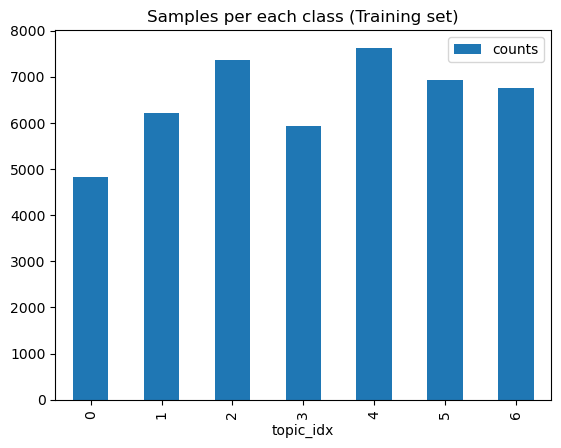

In [7]:
# 분포도 확인 
train.groupby(train.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

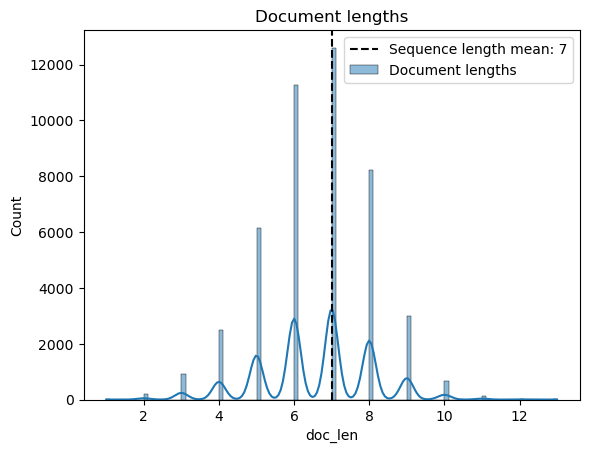

가장 긴 문장은 13개의 단어를, 가장 짧은 문장은 1개의 단어를 가지고 있습니다.


In [8]:
# 문장 길이 계산 (단어 수)
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe['doc_len'].mean()).astype(int)
    
    # distplot -> displot 또는 histplot으로 변경
    sns.histplot(dataframe['doc_len'], kde=True, label='Document lengths')
    
    # 평균 길이 선 추가
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean: {mean_seq_len}')
    
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    
    # 가장 긴 문장과 가장 짧은 문장의 단어 수 출력
    print(f"가장 긴 문장은 {train['doc_len'].max()}개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()}개의 단어를 가지고 있습니다.")

# 함수 실행
plot_doc_lengths(train)


#### [ 데이터셋 분리 ]<hr>

In [9]:
## 데이터셋 : 학습용/검증용/테스트용 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train['title'], train['topic_idx'], 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=train['topic_idx'])

In [10]:
print('--------훈련 데이터의 비율-----------')
print(f'IT과학 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'경제 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'사회 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')
print(f'생활문화 = {round(y_train.value_counts()[3]/len(y_train) * 100,3)}%')
print(f'세계 = {round(y_train.value_counts()[4]/len(y_train) * 100,3)}%')
print(f'스포츠 = {round(y_train.value_counts()[5]/len(y_train) * 100,3)}%')
print(f'정치 = {round(y_train.value_counts()[6]/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'IT과학 = {round(y_valid.value_counts()[0]/len(y_valid) * 100,3)}%')
print(f'경제 = {round(y_valid.value_counts()[1]/len(y_valid) * 100,3)}%')
print(f'사회 = {round(y_valid.value_counts()[2]/len(y_valid) * 100,3)}%')
print(f'생활문화 = {round(y_valid.value_counts()[3]/len(y_valid) * 100,3)}%')
print(f'세계 = {round(y_valid.value_counts()[4]/len(y_valid) * 100,3)}%')
print(f'스포츠 = {round(y_valid.value_counts()[5]/len(y_valid) * 100,3)}%')
print(f'정치 = {round(y_valid.value_counts()[6]/len(y_valid) * 100,3)}%')

--------훈련 데이터의 비율-----------
IT과학 = 10.566%
경제 = 13.63%
사회 = 16.127%
생활문화 = 12.995%
세계 = 16.71%
스포츠 = 15.185%
정치 = 14.788%
--------검증 데이터의 비율-----------
IT과학 = 10.568%
경제 = 13.624%
사회 = 16.121%
생활문화 = 13.0%
세계 = 16.712%
스포츠 = 15.19%
정치 = 14.785%


[ 단어사전 생성 ]<hr>

In [11]:
# from konlpy.tag import Komoran

# # Komoran 객체 생성
# komoran = Komoran()

# # train 데이터프레임에서 35만 개만 선택
# train_sample = train.head(400000)

# # 형태소 분석 및 명사 추출
# # 여러 문장에 대해 분석을 수행할 때는 apply를 사용하여 각 문장을 처리
# morphs = train_sample['title'].apply(komoran.morphs)
# nouns = train_sample['title'].apply(komoran.nouns)

# # 첫 10개의 결과만 출력
# print("형태소 분석 (첫 10개 문장):", morphs.head(10))
# print("명사 추출 (첫 10개 문장):", nouns.head(10))

In [12]:
# train 데이터프레임에서 40만 개만 선택
X_train_sample = X_train.head(400000)

In [13]:
# 불용어 파일 로드
STOPWORD_FILE = r'C:\Users\KDT-37\Desktop\KDT_7\11_NLP\D250409\koreanStopwords_unique.txt'

with open(STOPWORD_FILE, mode='r', encoding='utf-8') as f:
    stop_words = f.readlines()

stop_words = [word.replace('\n', '') for word in stop_words]

In [14]:
# 한국어 구두점 리스트
korean_punctuation = ['.', ',', '!', '?', '(', ')', '[', ']', '{', '}', '-', '...', '"',':', ';', '•']

In [15]:
from konlpy.tag import Komoran
import string

komoran = Komoran() 
# 토큰화 진행 기능 함수
def tokenize(sentences):
    tokenized_sentences = []

    # tqdm을 사용하여 진행 상태를 출력
    for sent in tqdm(sentences, total=len(sentences)):
        sent = str(sent)
        print("원본 문장:", sent)
        
        # 형태소 분석 (morphs는 형태소 단위로 나누는 메서드)
        morphs = komoran.morphs(sent)
        print("형태소 분석:", morphs)

        # 구두점 제거, 불용어 제거
        cleaned_tokens = []
        for token in morphs:
            # 영어 구두점과 한국어 구두점 및 불용어를 제거
            if token not in string.punctuation and token not in korean_punctuation and token not in stop_words:
                cleaned_tokens.append(token)

        tokenized_sentences.append(cleaned_tokens)

    return tokenized_sentences

In [16]:
X_train_sample.head(5)


39180             방글라데시 전 독재자 에르샤드 노환으로 별세
2132              알파고 충격 ③ 한국판 알파고 언제쯤 나올까
13135    스포츠10대뉴스 ⑦아시안게임 야구 금메달에도 병역 논란...
16386             성신양회 신설 사모투자회사에 200억원 출자
23487           프로야구 전망대 5말 6초는 중위권 혈투와 함께
Name: title, dtype: object

In [ ]:
from konlpy.tag import Komoran
import string
from tqdm import tqdm

# Komoran 객체 생성 (형태소 분석기)
komoran = Komoran()

# 불용어 리스트 로드
STOPWORD_FILE = r'C:\Users\KDT-37\Desktop\KDT_7\11_NLP\D250409\koreanStopwords_unique.txt'

with open(STOPWORD_FILE, mode='r', encoding='utf-8') as f:
    stop_words = f.readlines()

# 불용어 리스트에서 줄바꿈 제거
stop_words = [word.replace('\n', '') for word in stop_words]

# 한국어 구두점 리스트
korean_punctuation = ['∼','%', '.', ',', '!', 
                      '?', '(', ')', '[', ']', 
                      '{', '}', '-', '...', '"', 
                      ':', ';', '·', '…']


# 한국어 자음 리스트
korean_consonants = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 
                     'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 
                     'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']


# 토큰화 진행 기능 함수
def tokenize(sentences):
    tokenized_sentences = []

    # tqdm을 사용하여 진행 상태를 출력
    for sent in tqdm(sentences, total=len(sentences)):
        sent = str(sent)

        # 형태소 분석 (morphs는 형태소 단위로 나누는 메서드)
        morphs = komoran.morphs(sent)

        # 구두점, 불용어, 숫자, 조사 제거
        cleaned_tokens = []
        for token in morphs:
            # 한국어 구두점, 불용어, 숫자, 조사 제거
            if token not in korean_punctuation and token not in stop_words and not token.isdigit() and token not in korean_consonants:
                cleaned_tokens.append(token)

        tokenized_sentences.append(cleaned_tokens)

    return tokenized_sentences



In [18]:
# X_train에서 'title' 컬럼만 리스트로 변환하여 토큰화 함수에 적용
tokenized_X_train = tokenize(X_train)
tokenized_X_valid = tokenize(X_valid)
tokenized_X_test = tokenize(test['title'])


# 결과 출력
print("토큰화된 결과:", tokenized_X_train[:10])  # 앞 10개만 출력하여 확인
print("토큰화된 결과:", tokenized_X_valid[:10])
print("토큰화된 결과:", tokenized_X_test[:10])


100%|██████████| 9131/9131 [00:03<00:00, 2928.53it/s]

토큰화된 결과: [['방글라데시', '전', '독재자', '에르샤드', '노환', '별세'], ['알파고', '충격', '한국판', '알파고', '쯤'], ['스포츠', '10대', '뉴스', '아시안게임', '야구', '금메달', '병역', '논란'], ['성신양회', '신설', '사모', '투자', '회사', '억', '출자'], ['프로', '야구', '전망대', '초', '중위', '권', '혈투'], ['유가', '발목', '잡히', '인도네시아', '예산', '삭감', '난관', '돌파'], ['러시아', '불임', '부부', '韓', '원정', '임신', '인기', '연해주', '만도', '月', '쌍'], ['한반도', '新', '냉전', '朴', '대통령', '北', '묻', '핵', '냐', '생존', '냐'], ['게시판', '교보문고', '드라마', '수', '로맨스', '웹', '소설', '공모'], ['과기', '정통부', 'SKB', '티브로드', '인수', '합병', '조건부', '인가']]
토큰화된 결과: [['붕괴', '伊', '모란', '디', '다리', '25년', '간', '제대로', '유지', '보수', '종합'], ['이틀', '노트', '넘', 'S8', '예약', '판매', '유통', '북새통', '종합'], ['올림픽', '개막식', '참석', '김여정'], ['추신수', '안타', '없이', '사사구', '텍사스', '짜릿', '역전승'], ['美', '규제', '철강', '株', '엇갈리', '반응', '영향', '제한', '분석'], ['전국', '곳곳', '가을', '비', '흠뻑', '밤', '남해안', '제주', '호우'], ['출연', '연', '중소기업', '교류', '장', '기술', '지원', '협의회', '출범'], ['한국당', '중국', '러시아', '군용기', '침범', '관련', '기자회견'], ['친박', '계', '김무성', '권력자', '발언', '발끈', '확전', '자제'], [

In [19]:
print(f'tokenized_X_valid : {len(tokenized_X_train)}개')
print(f'tokenized_X_valid : {len(tokenized_X_valid)}개')
print(f'tokenized_X_test : {len(tokenized_X_test)}개')

tokenized_X_valid : 36523개
tokenized_X_valid : 9131개
tokenized_X_test : 9131개


In [20]:
# 상위 샘플 2개 출력
for sent in tokenized_X_train[:2]:
  print(sent)

['방글라데시', '전', '독재자', '에르샤드', '노환', '별세']
['알파고', '충격', '한국판', '알파고', '쯤']


In [21]:
# 상위 샘플 2개 출력
for sent in tokenized_X_valid[:2]:
  print(sent)

['붕괴', '伊', '모란', '디', '다리', '25년', '간', '제대로', '유지', '보수', '종합']
['이틀', '노트', '넘', 'S8', '예약', '판매', '유통', '북새통', '종합']


#### [ Vocab 생성 ]<hr>

In [22]:
## Vocab 생성 시 단어 빈도 처리 위한 python기본 모듈
from collections import Counter

word_list = []
for sent in tokenized_X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 25824


In [23]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 100개 단어')
print(vocab[:100])

등장 빈도수 상위 100개 단어
['종합', '대통령', '美', '北', '억', '전', '대', '위', '한국', '시', '천', '이란', '감독', '출시', '中', '경기', '게시판', '화', '트럼프', '대표', '신간', '朴', '프로', '성', '농구', '정부', '차', '게', '팀', '문', '서울', 'KT', '비', '개발', '조', '분기', '지원', '투자', 'G', '새', '권', '시장', '금융', '가능', '수', '배구', '면', '중국', '올해', '개최', '공개', '미', '최고', '영업', '세계', '日', '라', '미국', '작년', '당', '후', '총리', '기술', '피', '축구', '기업', '코로나', '삼성', '미래', '김정은', '간', '민주', '사망', '호', '월드컵', '전국', '장', '그래픽', '시즌', '서비스', '국내', '최대', '靑', '북', 'AI', '재', '추진', '터키', '대회', '류현진', '북한', '축제', '여행', '내년', '내일', '↑', '형', '방문', '국회', '경제']


In [71]:
import csv
# 전체 vocab을 csv 파일로 저장
with open('전체_vocab.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['단어'])  # 헤더 작성
    
    # 전체 vocab을 파일에 기록
    for word in vocab:
        writer.writerow([word, word_counts[word]])

print("전체 vocab 단어와 빈도수가 '전체_vocab.csv' 파일에 저장되었습니다.")

전체 vocab 단어와 빈도수가 '전체_vocab.csv' 파일에 저장되었습니다.


In [24]:
threshold  = 3
total_cnt  = len(word_counts) # 단어의 수
rare_cnt   = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq  = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25824
등장 빈도가 2번 이하인 희귀 단어의 수: 13775
단어 집합에서 희귀 단어의 비율: 53.34185254027262
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.851951923045007


In [25]:
## 단어사전 -> 단어:정수값
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [26]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

In [27]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 25826


In [28]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1


#### [ 정수 인코딩 ]<hr>

In [29]:
## 문장단위 추출 후 단어들을 정수로 인코딩 진행 함수
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [30]:
encoded_X_train = texts_to_sequences(tokenized_X_train, word_to_index)
encoded_X_valid = texts_to_sequences(tokenized_X_valid, word_to_index)

In [31]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[6728, 7, 3944, 15906, 15907, 1169]
[1232, 1170, 6729, 1232, 5134]


In [32]:
# 정수 -> 단어 변환 사전(예 : 영한사전, 기계어자연어사전)
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [33]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[1]]
print('기존의 두번째 샘플 :', tokenized_X_train[1])
print('복원된 두번째 샘플 :', decoded_sample)

기존의 두번째 샘플 : ['알파고', '충격', '한국판', '알파고', '쯤']
복원된 두번째 샘플 : ['알파고', '충격', '한국판', '알파고', '쯤']


#### [ 패딩 ]<hr>

뉴스 제목의 최대 길이 : 18
뉴스 제목의 평균 길이 : 8.248692604660077


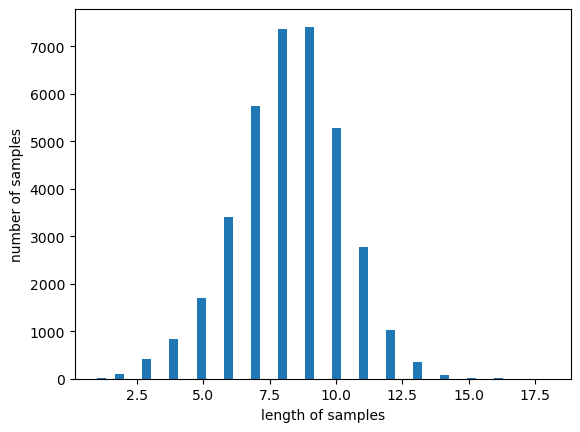

In [34]:
print('뉴스 제목의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('뉴스 제목의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

In [36]:
padded_X_train = pad_sequences(encoded_X_train, max_len=17)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=17)

In [37]:
print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)

훈련 데이터의 크기 : (36523, 17)
검증 데이터의 크기 : (9131, 17)


In [38]:
print(padded_X_train.shape[:2])

(36523, 17)


#### [ 모델링 ] <hr>

In [39]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))

In [40]:
train_label_tensor[:5]

tensor([4, 0, 5, 1, 5])

In [41]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [61]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=2, dropout=0.3, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        # 양방향이면 hidden_dim * 2
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]  # 마지막 레이어의 hidden state
        
        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [62]:
from tqdm import tqdm  # tqdm 라이브러리 import

# 모델 학습 함수 (조기 종료 및 최적 모델 저장 포함)
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=5, patience=3):
    model.train()
    best_valid_loss = float('inf')  # 최상의 검증 손실 초기화
    epochs_without_improvement = 0  # 개선되지 않은 에폭 수
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    for epoch in range(epochs):
        total_loss = 0
        all_preds = []  # 모든 예측값을 저장
        all_labels = []  # 모든 실제값을 저장
        
        model.train()  # 학습 모드로 설정
        
        # tqdm을 사용하여 학습 데이터에 대한 진행 바 표시
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False):
            optimizer.zero_grad()
            
            inputs = torch.clamp(inputs, max=vocab_size-1)
            
            # 모델 출력 얻기
            outputs = model(inputs)  
            
            # 손실 계산
            loss = criterion(outputs, labels)
            
            # 역전파 및 최적화
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # 예측값과 실제값을 리스트에 저장
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        # 훈련 정확도와 F1 스코어 계산
        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # 평균 훈련 손실 출력
        print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader):.4f}")
        print(f"Epoch {epoch + 1}, Training Accuracy: {train_accuracy * 100:.2f}%")
        print(f"Epoch {epoch + 1}, Training F1 Score: {train_f1:.4f}")
        
        # 검증 손실 계산
        # 에폭마다 검증 손실을 기준으로 학습률 갱신
        valid_loss, accuracy, f1 = evaluate_model(model, valid_loader, criterion)
        scheduler.step(valid_loss)  # 검증 손실을 기준으로 학습률 감소
        print(f"Epoch {epoch + 1}, Validation Loss: {valid_loss:.4f}, Accuracy: {accuracy * 100:.2f}%, F1 Score: {f1:.4f}")
        
        # 조기 종료 조건 체크 (검증 손실이 개선되지 않으면)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_without_improvement = 0
            # 모델 저장 (최적 모델)
            torch.save(model.state_dict(), "0415_LSTM_binary_best_model.pth")
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break  # 학습 종료


In [63]:
from tqdm import tqdm  # tqdm 라이브러리 import

# 검증 함수 (손실, 정확도, F1-score 계산)
def evaluate_model(model, valid_loader, criterion):
    model.eval()  # 평가 모드로 설정
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # 평가 시 기울기 계산을 하지 않음
        # tqdm을 사용하여 검증 데이터에 대한 진행 바 표시
        for batch in tqdm(valid_loader, desc="Validating", leave=False):
            # `inputs`와 `labels` 분리
            inputs, labels = batch
            inputs = torch.clamp(inputs, max=vocab_size-1)
            
            # 모델 출력 얻기
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)  # 예측값 추출
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            # 전체 레이블과 예측을 저장하여 F1-score 계산에 사용
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    avg_loss = total_loss / len(valid_loader)  # 평균 손실 계산
    accuracy = correct_predictions / total_predictions  # 정확도 계산
    f1 = f1_score(all_labels, all_preds, average='weighted')  # F1-score 계산 (weighted 방식)
    
    return avg_loss, accuracy, f1


In [64]:
from torch.utils.data import DataLoader, TensorDataset

encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = TensorDataset(encoded_train, train_label_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = TensorDataset(encoded_valid, valid_label_tensor)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=32, drop_last=True)

In [65]:
for inputs, labels in train_loader:
    print(inputs.shape)  # 데이터 크기 확인
    break  # 첫 번째 배치만 확인

torch.Size([64, 17])


In [66]:
for inputs, labels in valid_loader:
    print(inputs.shape)  # 데이터 크기 확인
    break  # 첫 번째 배치만 확인

torch.Size([32, 17])


In [67]:
# 모델 인스턴스 생성
vocab_size = len(vocab)+1       # 전체 단어 사전 크기
embed_dim = 200               # 임베딩 차원
hidden_dim = 128              # RNN hidden state 크기
output_dim = 7                # 클래스 수
lr = 0.0005
num_epochs = 20

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr )

In [70]:
print(vocab_size)

25825


In [68]:
# 데이터 확인 코드
for inputs, labels in train_loader:
    print(f"Max input index: {inputs.max()}")  # 최대 인덱스 확인
    print(f"Min input index: {inputs.min()}")  # 최소 인덱스 확인
    break

Max input index: 24900
Min input index: 0


In [69]:
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=num_epochs, patience=3)

c:\Users\KDT-37\anaconda3\envs\NLP\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 1.0009
Epoch 1, Training Accuracy: 64.51%
Epoch 1, Training F1 Score: 0.6425


Epoch 1, Validation Loss: 0.6423, Accuracy: 78.30%, F1 Score: 0.7858


Epoch 2, Training Loss: 0.4829
Epoch 2, Training Accuracy: 84.08%
Epoch 2, Training F1 Score: 0.8410


Epoch 2, Validation Loss: 0.5605, Accuracy: 81.17%, F1 Score: 0.8112


Epoch 3, Training Loss: 0.3151
Epoch 3, Training Accuracy: 89.82%
Epoch 3, Training F1 Score: 0.8981


Epoch 3, Validation Loss: 0.5819, Accuracy: 81.43%, F1 Score: 0.8147


Epoch 4, Training Loss: 0.2074
Epoch 4, Training Accuracy: 93.51%
Epoch 4, Training F1 Score: 0.9350


Epoch 4, Validation Loss: 0.6098, Accuracy: 81.37%, F1 Score: 0.8130


Epoch 5, Training Loss: 0.1373
Epoch 5, Training Accuracy: 95.74%
Epoch 5, Training F1 Score: 0.9573


Epoch 5, Validation Loss: 0.6836, Accuracy: 80.93%, F1 Score: 0.8107
Early stopping triggered after 5 epochs.


[ 성능 지표 시각화 ]<hr>

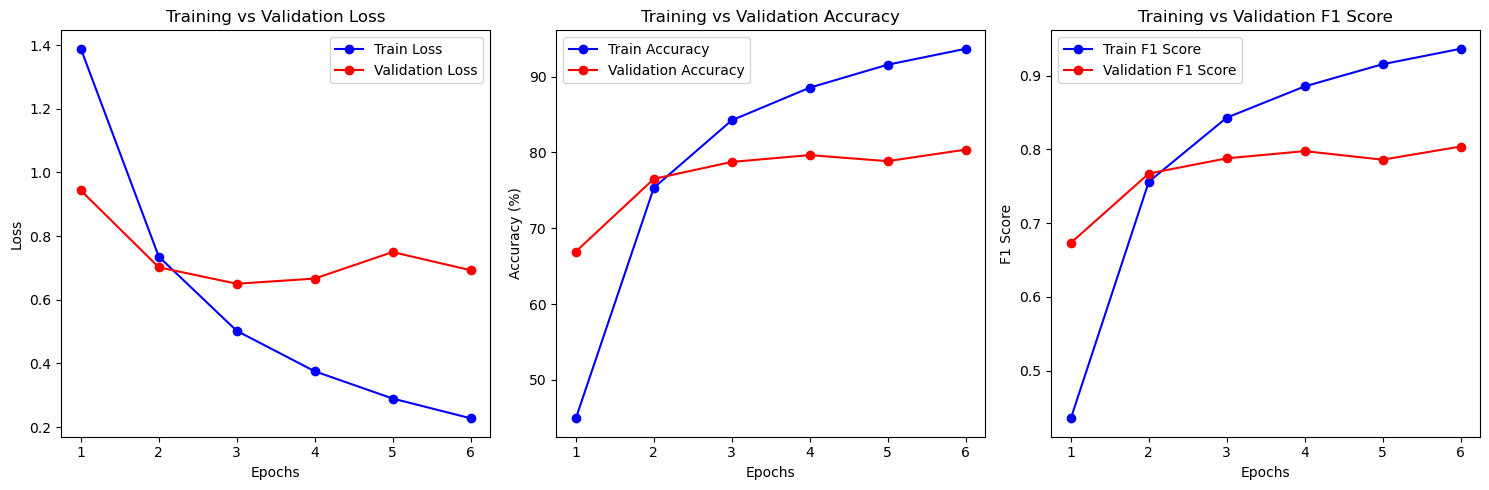

In [60]:

# Epoch 별 성능 지표
epochs = [1, 2, 3, 4, 5, 6]

# Training Loss, Accuracy, F1-Score
train_losses = [1.3881, 0.7351, 0.5023, 0.3753, 0.2897, 0.2277]
train_accuracies = [44.94, 75.33, 84.24, 88.54, 91.57, 93.67]
train_f1_scores = [0.4354, 0.7563, 0.8432, 0.8856, 0.9157, 0.9366]

# Validation Loss, Accuracy, F1-Score
valid_losses = [0.9431, 0.7018, 0.6502, 0.6664, 0.7497, 0.6928]
valid_accuracies = [66.93, 76.51, 78.75, 79.65, 78.85, 80.37]
valid_f1_scores = [0.6733, 0.7674, 0.7880, 0.7978, 0.7862, 0.8040]

# 시각화
plt.figure(figsize=(15, 5))

# 훈련 손실과 검증 손실
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, valid_losses, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# 훈련 정확도와 검증 정확도
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

# 훈련 F1-Score와 검증 F1-Score
plt.subplot(1, 3, 3)
plt.plot(epochs, train_f1_scores, label='Train F1 Score', color='blue', marker='o')
plt.plot(epochs, valid_f1_scores, label='Validation F1 Score', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training vs Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

[ 모델 활용 ]<hr>

In [ ]:
# 모델 인스턴스 생성
vocab_size = len(vocab)       # 전체 단어 사전 크기
embed_dim = 200               # 임베딩 차원
hidden_dim = 128              # RNN hidden state 크기
output_dim = 7                # 클래스 수
lr = 0.0005
num_epochs = 20

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr )

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# 모델 불러오기
model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('LSTM_best_model.pth'))  # 저장한 모델 경로
model.to(device)
model.eval()  # 평가 모드로 설정

# 테스트 데이터 준비
# TensorDataset은 input_ids, attention_mask, labels를 포함하는 형태여야 합니다
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 예측 함수
def predict(model, test_loader, device):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # 평가 시 기울기 계산을 하지 않음
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # 모델 예측
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # 예측값 저장
            _, predicted = torch.max(logits, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 결과 계산
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return accuracy, f1

# 테스트셋에 대한 예측 실행
accuracy, f1 = predict(model, test_loader, device)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test F1 Score: {f1:.4f}")

RuntimeError: Error(s) in loading state_dict for RNNClassifier:
	Missing key(s) in state_dict: "rnn.weight_ih_l0", "rnn.weight_hh_l0", "rnn.bias_ih_l0", "rnn.bias_hh_l0", "rnn.weight_ih_l1", "rnn.weight_hh_l1", "rnn.bias_ih_l1", "rnn.bias_hh_l1". 
	Unexpected key(s) in state_dict: "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0", "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1". 
	size mismatch for embedding.weight: copying a param with shape torch.Size([19617, 200]) from checkpoint, the shape in current model is torch.Size([25824, 200]).